## Import

In [1]:
import random
import pandas as pd
import numpy as np
import os
import librosa
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from tqdm.auto import tqdm

import warnings
warnings.filterwarnings(action='ignore') 

## Hyperparameter Setting

In [2]:
CFG = {
    'SR':16000,
    'N_MFCC':128, # MFCC 벡터를 추출할 개수 (<=128)
    'SEED':41
}

## Fixed RandomSeed

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(CFG['SEED']) # Seed 고정

## Data Pre-processing

In [5]:
train_df = pd.read_csv('./data/open/train.csv') # 모두 정상 Sample
test_df = pd.read_csv('./data/open/test.csv')

In [25]:
train_df['SAMPLE_PATH']=train_df['SAMPLE_PATH'].str.replace('./train','./data/open/train')

'./data/open/train/TRAIN_0000.wav'

In [22]:
test_df['SAMPLE_PATH']=test_df['SAMPLE_PATH'].str.replace('./test','./data/open/test')

In [26]:
def get_mfcc_feature(df):
    features = []
    for path in tqdm(df['SAMPLE_PATH']):
        # librosa패키지를 사용하여 wav 파일 load
        y, sr = librosa.load(path, sr=CFG['SR'])
        
        # librosa패키지를 사용하여 mfcc 추출
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

        y_feature = []
        # 추출된 MFCC들의 평균을 Feature로 사용
        for e in mfcc:
            y_feature.append(np.mean(e,axis=1))
        features.append(y_feature)
    return features

In [50]:
np.mean(mfcc,axis=1).shape

(128,)

In [54]:
len(train_features[0])

128

In [44]:
features = []
y, sr = librosa.load(train_df['SAMPLE_PATH'][0], sr=CFG['SR'])

# librosa패키지를 사용하여 mfcc 추출
mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=CFG['N_MFCC'])

# 추출된 MFCC들의 평균을 Feature로 사용
y_feature.append(np.mean(e,axis=1))
features.append(y_feature)

AxisError: axis 1 is out of bounds for array of dimension 1

In [27]:
train_features = get_mfcc_feature(train_df)
test_features = get_mfcc_feature(test_df)

  0%|          | 0/1279 [00:00<?, ?it/s]

  0%|          | 0/1514 [00:00<?, ?it/s]

## Model Fit

In [28]:
model = IsolationForest(n_estimators=200, max_samples=256, contamination='auto', random_state=CFG['SEED'], verbose=0)
model.fit(train_features)

IsolationForest(max_samples=256, n_estimators=200, random_state=41)

In [82]:
test_pred_proba = model.decision_function(test_features)

threshold = 0
pred = (test_pred_proba<threshold)*1

(array([  1.,  27.,  89., 145., 230., 215., 272., 149., 180., 206.]),
 array([-0.12278023, -0.09808842, -0.07339661, -0.04870479, -0.02401298,
         0.00067883,  0.02537064,  0.05006246,  0.07475427,  0.09944608,
         0.12413789]),
 <BarContainer object of 10 artists>)

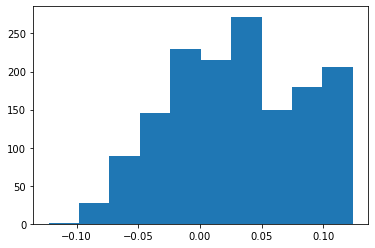

In [83]:
import matplotlib.pyplot as plt

plt.hist(test_pred_proba)

In [84]:
pred.mean()

0.3177014531043593

## Prediction

In [85]:
# def get_pred_label(model_pred):
#     # IsolationForest 모델 출력 (1:정상, -1:불량) 이므로 (0:정상, 1:불량)로 Label 변환
#     model_pred = np.where(model_pred == 1, 0, model_pred)
#     model_pred = np.where(model_pred == -1, 1, model_pred)
#     return model_pred

In [86]:
# test_pred = model.predict(test_features) # model prediction
# test_pred = get_pred_label(test_pred)

## Submission

In [87]:
submit = pd.read_csv('./data/open/sample_submission.csv')

In [88]:
submit['LABEL'] = pred
submit.head()

,SAMPLE_ID,LABEL
0,TEST_0000,0
1,TEST_0001,0
2,TEST_0002,0
3,TEST_0003,1
4,TEST_0004,1


In [89]:
submit.to_csv('./submit.csv', index=False)